# Solving (Set) Constraints in B and Event-B #
Michael Leuschel,
David Geleßus (Jupyter Interface)

## A quick Introduction to B ##

### Basic Datavalues in B ###

B provides the booleans, strings and integers as built-in datatypes. (Strings are not available in Event-B.)

In [1]:
BOOL

$\{\mathit{FALSE},\mathit{TRUE}\}$

In [2]:
"this is a string"

$\text{"this is a string"}$

In [3]:
1024

$1024$

Users can define their own datatype in a B machine.
One distinguishes between explicitly specified enumerated sets and deferred sets.

In [4]:
::load
MACHINE MyBasicSets
SETS Trains = {thomas, gordon}; Points
END

Loaded machine: MyBasicSets

For animation and constraint solving purposes, ProB will instantiate deferred sets to some finite set (the size of which can be controlled and is partially inferred).

In [5]:
Points

$\{\mathit{Points1},\mathit{Points2}\}$

### Pairs ###
B also has pairs of values, which can be written in two ways:

In [6]:
(thomas,10)

$(\mathit{thomas}\mapsto 10)$

In [7]:
thomas |-> 10

$(\mathit{thomas}\mapsto 10)$

**Tuples** simply correspond to nested pairs:

In [8]:
(thomas |-> gordon |-> 20)

$((\mathit{thomas}\mapsto \mathit{gordon})\mapsto 20)$

Classical B also provides **records**, i.e., tuples with named fields:

In [9]:
:prettyprint r=rec(train:thomas,length:20,position:10302)

r = rec(length:20,position:10302,train:thomas)

### Sets ###
Sets in B can be specified in multiple ways.
For example, using explicit enumeration:

In [10]:
{1,3,2,3}

$\{1,2,3\}$

or via a predicate by using a **set comprehension**:

In [11]:
{x|x>0 & x<4}

$\{1,2,3\}$

For integers there are a variety of other sets, such as intervals:

In [12]:
1..3

$\{1,2,3\}$

or the set of implementable integers INT = MININT..MAXINT or the set of implementable natural numbers NAT = 0..MAXINT.

Sets can be **higher-order** and contain other sets:

In [13]:
{ 1..3,  {1,2,3,2}, 0..1, {x|x>0 & x<4} }

$\{\{0,1\},\{1,2,3\}\}$

**Relations** are modelled as sets of pairs:

In [14]:
{ thomas↦gordon, gordon↦gordon, thomas↦thomas}

$\{(\mathit{thomas}\mapsto \mathit{thomas}),(\mathit{thomas}\mapsto \mathit{gordon}),(\mathit{gordon}\mapsto \mathit{gordon})\}$

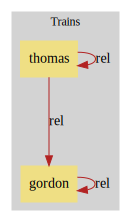

In [15]:
:dot expr_as_graph ("rel",{ thomas|->gordon, gordon|->gordon, thomas|->thomas})

Note: a pair is an element of a Cartesian product, and a relation is just a subset of a Cartesian product.
The above relation is a subset of ```Trains * Trains```.

In [16]:
:pref DOT_ENGINE=circo

Preference changed: DOT_ENGINE = circo


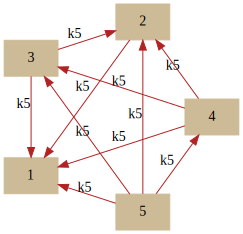

In [17]:
:dot expr_as_graph ("k5",{x,y|x:1..5 & y:1..5 & x>y})

**Functions** are relations which map every domain element to at most one value:

In [18]:
{ thomas↦1, gordon↦2}

$\{(\mathit{thomas}\mapsto 1),(\mathit{gordon}\mapsto 2)\}$

**Sequences** are just functions whose domain is 1..n for some n:

In [19]:
[4,5,6] = {1↦4, 2↦5, 3↦6}

$\mathit{TRUE}$

## Expressions vs Predicates vs Substitutions ##


### Expressions ###
Expressions in B have a value. With ProB and with ProB's Jupyter backend, you can evaluate expresssions such as:

In [20]:
2**1000

$10715086071862673209484250490600018105614048117055336074437503883703510511249361224931983788156958581275946729175531468251871452856923140435984577574698574803934567774824230985421074605062371141877954182153046474983581941267398767559165543946077062914571196477686542167660429831652624386837205668069376$

B provides many operators which return values, such as the usual arithmetic operators but also many operators for sets, relations and functions.
For example set union and set difference:

In [21]:
(1..3 \/ 5..10) \ (2..6)

$\{1,7,8,9,10\}$

In [22]:
(1..3 ∪ 5..10) \ (2..6)

$\{1,7,8,9,10\}$

The range of a relation or function:

In [23]:
dom({(thomas↦1),(gordon↦2)})

$\{\mathit{thomas},\mathit{gordon}\}$

Function application:

In [24]:
{(thomas↦1),(gordon↦2)} (thomas)

$1$

Relational inverse (.~) and relational image .[.] :

In [25]:
{(thomas↦1),(gordon↦2)}~[2..3]

$\{\mathit{gordon}\}$

## Predicates
ProB can also be used to evaluate predicates (B distinguishes between expressions which have a value and predicates which are either true or false).

In [26]:
2>3

$\mathit{FALSE}$

In [27]:
3>2

$\mathit{TRUE}$

Within predicates you can use **open** variables, which are implicitly existentially quantified.
ProB will display the solution for the open variables, if possible.

In [28]:
x*x=100

$\mathit{TRUE}$

**Solution:**
* $\mathit{x} = -10$

We can find all solutions to a predicate by using the set comprehension notation.
Note that by this we turn a predicate into an expression.

In [29]:
{x|x*x=100}

$\{-10,10\}$

### Substitutions (Statements) ###
B also has a rich syntax for **substitutions**, aka statements.
For example ```x := x+1``` increments the value of x by 1.
Other constructs are WHILE loops and CASE statements.
We will not talk about substitutions in the rest of this presentation.
But B can provide a nice mixture of **functional programming**, **constraint programming** and **imperative programming**, with precise proof rules rooted in logic.

## Definition of Constraint Solving ##

Constraint solving is determine whether a predicate with open/existentially quantified variables is satisfiable and providing values for the open variables in case it is.
We have already solved the predicate ```x*x=100``` above, yielding the solution ```x=-10```.
The following is an unsatisfiable predicate:

In [30]:
:prettyprint #x.(x:NATURAL & x*x=1000)

∃x·(x ∈ ℕ ∧ x * x = 1000)

The difference to **proof** is that in constraint solving one has to produce a solution (aka a model). The difference to **execution** is that not all variables are known.

## Constraint Solving Applications ##
Constraint solving has many applications in formal methods in general and B in particular:
* Animation, in particular dealing with implict specifications to determine parameters
* Test-case generation
* Bounded Model Checking
* Disprover and prover
* Enabling analysis (determining implicit control flow)
and many more



As no counter example has been found, we can in this case establish the goal to be proven.

### Modelling and Solving Problems in B ###

Obviously, we can also use constraint solving in B to solve puzzles or real-life problems.
In other words, we use B as way to express constraint problems in almost pure mathematics.

#### Send More Money Puzzle ####
We now try and solve the SEND+MORE=MONEY arithmetic puzzle in B, involving 8 distinct digits:

In [31]:
:prettyprint {S,E,N,D, M,O,R, Y} <: 0..9 & S >0 & M >0 & card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D + M*1000 + O*100 + R*10 + E = M*10000 + O*1000 + N*100 + E*10 + Y

{S,E,N,D,M,O,R,Y} ⊆ 0 ‥ 9 ∧ S > 0 ∧ M > 0 ∧ card({S,E,N,D,M,O,R,Y}) = 8 ∧ S * 1000 + E * 100 + N * 10 + D + M * 1000 + O * 100 + R * 10 + E = M * 10000 + O * 1000 + N * 100 + E * 10 + Y

In [32]:
{S,E,N,D, M,O,R, Y} ⊆ 0..9 & S >0 & M >0 & 
   card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D +
   M*1000 + O*100 + R*10 + E =
  M*10000 + O*1000 + N*100 + E*10 + Y

$\mathit{TRUE}$

**Solution:**
* $\mathit{R} = 8$
* $\mathit{S} = 9$
* $\mathit{D} = 7$
* $\mathit{E} = 5$
* $\mathit{Y} = 2$
* $\mathit{M} = 1$
* $\mathit{N} = 6$
* $\mathit{O} = 0$

We can find all solutions (to the unmodified puzzle) using a set comprehension and make sure that there is just a single solution:

In [33]:
  {S,E,N,D, M,O,R, Y |
   {S,E,N,D, M,O,R, Y} ⊆ 0..9 &  S >0 & M >0 & 
   card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D +
   M*1000 + O*100 + R*10 + E =
   M*10000 + O*1000 + N*100 + E*10 + Y }

$\{(((((((9\mapsto 5)\mapsto 6)\mapsto 7)\mapsto 1)\mapsto 0)\mapsto 8)\mapsto 2)\}$

In [34]:
:table   {S,E,N,D, M,O,R, Y |
   {S,E,N,D, M,O,R, Y} ⊆ 0..9 &  S >0 & M >0 & 
   card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D +
   M*1000 + O*100 + R*10 + E =
   M*10000 + O*1000 + N*100 + E*10 + Y }

|S|E|N|D|M|O|R|Y|
|---|---|---|---|---|---|---|---|
|$9$|$5$|$6$|$7$|$1$|$0$|$8$|$2$|


#### KISS PASSION Puzzle####
A slightly more complicated puzzle (involving multiplication) is the KISS * KISS = PASSION problem.

In [35]:
    {K,P} ⊆ 1..9 &
    {I,S,A,O,N} ⊆ 0..9 &
    (1000*K+100*I+10*S+S) * (1000*K+100*I+10*S+S) 
     =  1000000*P+100000*A+10000*S+1000*S+100*I+10*O+N &
    card({K, I, S, P, A, O, N}) = 7

$\mathit{TRUE}$

**Solution:**
* $\mathit{P} = 4$
* $\mathit{A} = 1$
* $\mathit{S} = 3$
* $\mathit{I} = 0$
* $\mathit{K} = 2$
* $\mathit{N} = 9$
* $\mathit{O} = 8$

In [36]:
:table {K,I,S,P,A,O,N |    {K,P} ⊆ 1..9 &
    {I,S,A,O,N} ⊆ 0..9 &
    (1000*K+100*I+10*S+S) * (1000*K+100*I+10*S+S) 
     =  1000000*P+100000*A+10000*S+1000*S+100*I+10*O+N &
    card({K, I, S, P, A, O, N}) = 7}

|K|I|S|P|A|O|N|
|---|---|---|---|---|---|---|
|$2$|$0$|$3$|$4$|$1$|$8$|$9$|


Finally, a simple puzzle involving sets is to find a subset of numbers from 1..5 whose sum is 14:

In [37]:
x <: 1..5 & SIGMA(y).(y:x|y)=14

$\mathit{TRUE}$

**Solution:**
* $\mathit{x} = \{2,3,4,5\}$

The well known n Queens problem can be solved as follows:

In [38]:
:time :solve prob n=8 &
    queens ∈ perm(1..n) &
    ∀(q1,q2).(q1∈1..n & q2∈2..n & q2>q1 ⇒ queens(q1)+(q2-q1) ≠ queens(q2) & queens(q1)+(q1-q2) ≠ queens(q2))

Execution time: 0.116087886 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{queens} = \{(1\mapsto 1),(2\mapsto 5),(3\mapsto 8),(4\mapsto 6),(5\mapsto 3),(6\mapsto 7),(7\mapsto 2),(8\mapsto 4)\}$
* $\mathit{n} = 8$

### Mixing Functional Programming with Constraint Programming ###

In B we can also define (higher-order) functions and mix those with logical predicates.


In [39]:
f = %x.(x:INTEGER|x*x) & // this is an infinite function
r1 = f(100000) &
r2 = f[1..10] &
r3 = ([2,3,5,7,11] ; f) & // relational composition ; corresponds to map
r4 = iterate(f,3)(2) & // we can apply the iteration or transitive closure operators
f(sqrt) = 100 // compute the square root of 100

$\newcommand{\qdot}{\mathord{\mkern1mu\cdot\mkern1mu}}\mathit{TRUE}$

**Solution:**
* $\mathit{r2} = \{1,4,9,16,25,36,49,64,81,100\}$
* $\mathit{r3} = [4,9,25,49,121]$
* $\mathit{r4} = 256$
* $\mathit{sqrt} = 10$
* $\mathit{f} = \lambda \mathit{x}\qdot(\mathit{x} \in \mathit{INTEGER}\mid \mathit{x} * \mathit{x})$
* $\mathit{r1} = 10000000000$

In [40]:
f = {x,y|x:NATURAL & y**2 >= x & (y-1)**2 <x } & // integer square root function
r1 = f(100000) &
r2 = f[1..10] &
r3 = ([2,3,5,7,11] ; f) &
r4 = iterate(f,3)(2) &
f(sqr) = 100 &
r5 = closure1(f)[{10000}]

$\newcommand{\cprod}{\mathbin\times}\newcommand{\cprod}{\mathbin\times}\mathit{TRUE}$

**Solution:**
* $\mathit{r2} = \{1,2,3,4\}$
* $\mathit{r3} = [2,2,3,3,4]$
* $\mathit{r4} = 2$
* $\mathit{r5} = \{2,4,10,100\}$
* $\mathit{sqr} = 9802$
* $\mathit{f} = \{\mathit{x},\mathit{y}\mid \mathit{x} \in \mathit{NATURAL} \land \mathit{y} \cprod 2 \geq \mathit{x} \land (\mathit{y} - 1) \cprod 2 < \mathit{x}\}$
* $\mathit{r1} = 317$

## How to solve (set) constraints in B ##

We will now examine how one can perform constraint solving for B.
ProB has three main solving backends
* the default solver using CLP(FD) and Prolog co-routines
* a SAT-based solver, using the Kodkod API of Alloy
* an SMT-based solver, using Z3 or CVC4


In [41]:
:time :solve prob n=20 &
    queens : perm(1..n) &
    ∀(q1,q2).(q1∈1..n & q2∈2..n & q2>q1 ⇒ queens(q1)+(q2-q1) ≠ queens(q2) & queens(q1)+(q1-q2) ≠ queens(q2))

Execution time: 0.071063304 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{queens} = \{(1\mapsto 1),(2\mapsto 3),(3\mapsto 5),(4\mapsto 14),(5\mapsto 17),(6\mapsto 4),(7\mapsto 16),(8\mapsto 7),(9\mapsto 12),(10\mapsto 18),(11\mapsto 15),(12\mapsto 19),(13\mapsto 6),(14\mapsto 10),(15\mapsto 20),(16\mapsto 11),(17\mapsto 8),(18\mapsto 2),(19\mapsto 13),(20\mapsto 9)\}$
* $\mathit{n} = 20$

In [42]:
:time :solve kodkod n=13 &
    queens : 1..n >-> 1..n &
    ∀(q1,q2).(q1∈1..n & q2∈2..n & q2>q1 ⇒ queens(q1)+(q2-q1) ≠ queens(q2) & queens(q1)+(q1-q2) ≠ queens(q2))

Execution time: 3.886160680 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{queens} = \{(3\mapsto 4),(5\mapsto 10),(6\mapsto 3),(7\mapsto 5),(9\mapsto 1),(10\mapsto 6),(11\mapsto 2),(12\mapsto 12),(13\mapsto 8),(1\mapsto 7),(2\mapsto 9),(4\mapsto 13),(8\mapsto 11)\}$
* $\mathit{n} = 13$

In [43]:
:time :solve z3 n=8 &
    queens : perm(1..n) &
    ∀(q1,q2).(q1∈1..n & q2∈2..n & q2>q1 ⇒ queens(q1)+(q2-q1) ≠ queens(q2) & queens(q1)+(q1-q2) ≠ queens(q2))

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

Result for KISS*KISS=PASSION puzzle:

Solver | Runtime
-------|-------
ProB Default | 0.01 sec
Kodkod Backend | 1 sec
Z3 Backend | ? > 100 sec

### Unbounded integers ###
The SAT translation via Kodkod/Alloy requires to determine the bid width.
It cannot be applied to unbounded integers.
Even for bounded integers it is quite tricky to get the bid widths correct: one needs also to take care of intermediate results. Alloy can detect incorrect models where an overflow occured, but to our understanding not where an overflow prevented a model (e.g., use inside negation or equivalence, see ```#(V.SS->V.SS)=0 iff no V.SS``` in paper at ABZ conference).

SMTLib is more tailored towards proof than towards model finding; as such it has typically no/less issues with unbounded values.
The ProB default solver can also deal with unbounded integers: it tries to narrow down domains to finite ones. If this fails, an unbounded variable is enumerated (partially) and an **enumeration warning** is generated. In case a solution is found, this warning is ignored, otherwise the result of ProB's analysis is **UNKNOWN**.
Some inconsistencies cannot be detected by interval/domain propagation; here it helps to activate ProB's CHR module which performs some additional inferences.

Let us perform some experiments. Both ProB and Z3 can solve the following:

In [44]:
:solve z3 x*x=100

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

Here is an example where ProB generates an enumeration warning, but finds a solution:

In [45]:
x>100 & x mod 2000 = 1 & x mod 3000 = 1

$\mathit{TRUE}$

**Solution:**
* $\mathit{x} = 6001$

In [46]:
:solve z3 x>100 & x mod 2000 = 1 & x mod 3000 = 1

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

Here ProB generates an enumeration warning and does not find a solution, hence the result is **UNKNOWN**. Here Z3 finds a solution.

In [47]:
:solve prob x>100 & x mod 2000 = 1 & x mod 3000 = 1 & (x+x) mod 4501 = 0

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

In [48]:
:solve z3 x>100 & x mod 2000 = 1 & x mod 3000 = 1 & (x+x) mod 4501 = 0

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

Here is an inconsistency which cannot be detected by CLP(FD)'s interval propagation.
ProB can detect it with CHR (Constraint Handling Rules) enabled, but without the module the result is **UNKNOWN**.

In [49]:
:solve z3 x>y & y>x

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

In [50]:
:solve prob x>y &y>x

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

### Summary for Integer Arithmetic ###

Solver | Unbounded | Model Finding | Inconsistency Detection (Unbounded)
------|------------|---------------|---
ProB CLP(FD) | yes | very good | limited with CHR
ProB Z3 | yes | reasonable | very good
ProB Kodkod | no | good | -


## Set Constraints ##

After booleans, integers and enumerated set elements, let us now move to constraint solving involving set variables.

### Translation to SAT ###
The Kodkod/Alloy backend translates sets bit vectors. The size of the vector is the number of possible elements.

Take for example the following constraint, the sets x and y are translated to bit vectors of size 2 and set union is simple bitwise or:

In [51]:
:solve kodkod  x ⊆ 1..2 & y ⊆ 1..2 & x ∪ y = 1..2 & 1∈x & x ⊂ y

$\mathit{TRUE}$

**Solution:**
* $\mathit{x} = \{1\}$
* $\mathit{y} = \{1,2\}$

Limitations of translating set constraints to SAT:
- this cannot deal with **unbounded** sets: we need to know a finite type for each set, so that we can generate a finite bit vector
- this approach cannot usually deal with **higher order** sets (sets of sets), as the size of the bit vector would be prohibitively large

Given that:

In [52]:
card(POW(1..100))

$1267650600228229401496703205376$

translating the following constraint to SAT would require a bit vector of length 1267650600228229401496703205376.

In [53]:
x ⊆ POW(1..100) & {100}∈x & ∀y.(y∈x ⇒ {card(y)}:x)

$\mathit{TRUE}$

**Solution:**
* $\mathit{x} = \{\{100\},\{1\}\}$

Also, in the following constraint, the set x is unbounded and no translation to SAT is feasible (without a very clever analysis of the universal implications).

In [54]:
{100}∈x & ∀y.(y∈x ⇒ (∀z.(z∈y ⇒ y ∪ {z / 2}∈x)))

$\mathit{TRUE}$

**Solution:**
* $\mathit{x} = \{\{100\},\{50,100\},\{25,50,100\},\{12,25,50,100\},\{6,12,25,50,100\},\{3,6,12,25,50,100\},\{1,3,6,12,25,50,100\},\{0,1,3,6,12,25,50,100\}\}$

However, when it is applicable the propositional encoding of sets can be very effective for SAT solvers.
The following example, involving various relational operators can currently only be solved by our Kodkod backend:

In [55]:
:time :solve kodkod r: 1..5 <-> 1..5 & (r;r) = r & r /= {} & dom(r)=1..5 & r[2..3]=4..5

Execution time: 0.078285006 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{r} = \{(3\mapsto 5),(3\mapsto 4),(5\mapsto 5),(5\mapsto 4),(1\mapsto 4),(2\mapsto 4),(4\mapsto 4)\}$

### Translation to SMTLib ###

This can in principle deal with higher-order sets and unbounded sets, but makes heavy use of quantifiers.
The practical usefulness is currently very limited.

In [56]:
:solve z3 x ⊆ 1..2 & y ⊆ 1..2 & x ∪ y = 1..2

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

Internally, the constraint is rewritten to support operators which do not exist in SMTLib:

Let us look at another relatively simple example which poses problems:

In [57]:
:solve z3 f = {1|->3, 2|->6} & r = f~[{6}]

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

To understand why this simple constraint cannot be solved, we have to know how the translation works:
The relational inverse gets translated into two universal quantifications for SMTLib:
```
 x = y~
<=>
 !(st11,st12).(st11 |-> st12 : x => st12 |-> st11 : y) & 
 !(st11,st12).(st12 |-> st11 : y => st11 |-> st12 : x))
```
Similarly, r = f[s] is translated as follows:
```
 r = f[s]
<=>
 !st27.(st27 : r => #st26.(st26 |-> st27 : f & st26 : s) & 
 !st27.(#st26.(st26 |-> st27 : f & st26 : s) => st27 : r)
```
The resulting predicate (without the inverse and image operators) is the following, which Z3 cannot solve (but ProB can).

In [58]:
:prettyprint f = {(1|->3),(2|->6)} &
#st13.(r = st13 & (
    !st15.(st15 : st13 => #st14.(#st16.(st14 |-> st15 : st16 & 
    (!(st17,st18).(st17 |-> st18 : st16 => st18 |-> st17 : f) & 
     !(st17,st18).(st18 |-> st17 : f => st17 |-> st18 : st16))) & st14 : {6})) & 
     !st15.(#st14.(#st19.(st14 |-> st15 : st19 & (!(st20,st21).(st20 |-> st21 : st19 => st21 |-> st20 : f) &
     !(st20,st21).(st21 |-> st20 : f => st20 |-> st21 : st19))) & st14 : {6}) => st15 : st13)))

f = {(1↦3),(2↦6)} ∧ (∃ /* LET */ (st13).( (st13)=r ∧ ∀st15·(st15 ∈ st13 ⇒ ∃st16·(6 ↦ st15 ∈ st16 ∧ (∀(st17,st18)·(st17 ↦ st18 ∈ st16 ⇒ st18 ↦ st17 ∈ f) ∧ ∀(st17,st18)·(st18 ↦ st17 ∈ f ⇒ st17 ↦ st18 ∈ st16)))) ∧ ∀st15·(∃st19·(6 ↦ st15 ∈ st19 ∧ (∀(st20,st21)·(st20 ↦ st21 ∈ st19 ⇒ st21 ↦ st20 ∈ f) ∧ ∀(st20,st21)·(st21 ↦ st20 ∈ f ⇒ st20 ↦ st21 ∈ st19))) ⇒ st15 ∈ st13)))

In [59]:
:time :solve prob f = {(1|->3),(2|->6)} &
#st13.(r = st13 & (
    !st15.(st15 : st13 => #st14.(#st16.(st14 |-> st15 : st16 & 
    (!(st17,st18).(st17 |-> st18 : st16 => st18 |-> st17 : f) & 
     !(st17,st18).(st18 |-> st17 : f => st17 |-> st18 : st16))) & st14 : {6})) & 
     !st15.(#st14.(#st19.(st14 |-> st15 : st19 & (!(st20,st21).(st20 |-> st21 : st19 => st21 |-> st20 : f) &
     !(st20,st21).(st21 |-> st20 : f => st20 |-> st21 : st19))) & st14 : {6}) => st15 : st13)))


Execution time: 0.066506694 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{r} = \{2\}$
* $\mathit{f} = \{(1\mapsto 3),(2\mapsto 6)\}$

In [60]:
:time :solve cvc4 f = {(1|->3),(2|->6)} &
#st13.(r = st13 & (
    !st15.(st15 : st13 => #st14.(#st16.(st14 |-> st15 : st16 & 
    (!(st17,st18).(st17 |-> st18 : st16 => st18 |-> st17 : f) & 
     !(st17,st18).(st18 |-> st17 : f => st17 |-> st18 : st16))) & st14 : {6})) & 
     !st15.(#st14.(#st19.(st14 |-> st15 : st19 & (!(st20,st21).(st20 |-> st21 : st19 => st21 |-> st20 : f) &
     !(st20,st21).(st21 |-> st20 : f => st20 |-> st21 : st19))) & st14 : {6}) => st15 : st13)))

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

The SMTLib translation is still of limited value for finding models.
However, for finding inconsistencies it is much better and can detect certain inconsistencies which ProB's solver cannot.
While both ProB and Z3 can solve the following:

In [61]:
:solve prob x:s1 & x:s2 & x /: (s1 /\ s2) & s1 <: INTEGER

$\mathit{FALSE}$

only the Z3 backend can solve this one:

In [62]:
:solve z3 x:s1 & x/:s2 & x /: (s1 \/s2) & s1 <: INTEGER

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

### ProB's Set Solver ###
ProB has actually three set representations:
- Prolog lists of elements
- AVL trees for fully known sets
- symbolic closures for large or infinite sets

For finite sets, the AVL tree representation is the most efficient and allows for efficient lookups.
It, however, requires all elements to be fully known.

The symbolic closure can be used for large or infinite sets.
ProB will automatically use it for sets it knows to be infinite, or when an enumeration warning occurs during an attempt at expanding a set.

The list representation is used for sets where some of the members are known or partially known.

#### AVL tree representation ####
The following generates the AVL tree representation:

In [63]:
{x|x∈0..2**10 & x mod 100 = 0}

$\{0,100,200,300,400,500,600,700,800,900,1000\}$

#### Symbolic closure representation ####

In the following case, ProB knows that the set is infinite and is kept symbolic:

In [64]:
{x|x>1000}

$\{\mathit{x}\mid \mathit{x} > 1000\}$

Symbolic sets can be used in various ways:

In [65]:
inf = {x|x>1000} & 1024 : inf & not(1000:inf) & res  = (900..1100) ∩ inf

$\newcommand{\upto}{\mathbin{.\mkern1mu.}}\mathit{TRUE}$

**Solution:**
* $\mathit{inf} = \{\mathit{x}\mid \mathit{x} > 1000\}$
* $\mathit{res} = (1001 \upto 1100)$

Internally, a symbolic representation is a **closure** in functional programming terms: all dependent variables are *compiled* into the closure: the closure can be passed as a value and evaluated without needing access to an environment. In Prolog this is represented as a tuple:
- closure(Parameters,Types,CompiledPredicate)
For example, a set {x|x>v} where v has the value 17 is compiled to:
- closure([x],[integer],```x>17```)

#### List representation ####
The list representation is used when a finite set is partially known and constraint solving has to determine the set.


In [66]:
vec: 1..10 --> 0..9999 &
vec(1) : {1,10} &
!x.(x:2..10 => vec(x) = vec(x-1)*2)

$\mathit{TRUE}$

**Solution:**
* $\mathit{vec} = \{(1\mapsto 1),(2\mapsto 2),(3\mapsto 4),(4\mapsto 8),(5\mapsto 16),(6\mapsto 32),(7\mapsto 64),(8\mapsto 128),(9\mapsto 256),(10\mapsto 512)\}$

Note that Kodkod translation and SMT translation not very effective for the above.

### ProB's Solving Algorithm ###

ProB tries to accomplish several conflicting goals:
- being able to deal with concrete data, i.e., sets and relations containing thousands or hundreds of thousands of elementas
- being able to deal with symbolic, infinite sets, relations and functions.
- being able to perform efficient computation over large data as well as constraint solving

For example, efficient computation over large concrete data is the following:

In [67]:
:time :solve prob s1 = {x|x:1..10**n & x mod n = 0} & s2 = {y|y:1..10**n & y mod (n+1) = 0} & s3 = s1 /\ s2 & n=4

Execution time: 0.592840941 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{s3} = \#500\in\{20,40,\ldots,9980,10000\}$
* $\mathit{n} = 4$
* $\mathit{s1} = \#2500\in\{4,8,\ldots,9996,10000\}$
* $\mathit{s2} = \#2000\in\{5,10,\ldots,9995,10000\}$

Here is a simple verison of the above

In the appendix there are more examples which analyse the performance for such examples.

ProB employs the *Andorra* principle: deterministic computations are done first.
As there are multiple set representations, there are actually two kinds of deterministic computations:
- deterministic computations that generate an efficient representation, e.g., an AVL set representation
- and other deterministic computations

The ProB solver has a **WAITFLAG store** where choice points and enumerations are registered with a given priority.
- Priority 0 means that an efficient representation can be generated
- Priority 1 is a deterministic computation not guaranteed to produce an efficient representation
- Priority k is a choice point/enumeration which may generate k possible values

At each solving step one waitflag is activated, the one with the lowest priority.
CLP(FD) variables are also registered in the WAITFLAG store and are enumerated before a waitflag of the same priority is activated. For tie breaking one typically uses the **most attached constraints first** (ffc) heuristic.

#### Example ####
Let us examine how ```x = 1..n & y = 2*n..3*n & n = 100 & xy = x \/ y``` is solved.
- all constraints are registered
- in phase 0 ```n=100``` is run
- this means that ```1..n``` can be efficiently computed
- this means that ```x = 1..n``` triggers in phase 0
- then ```2*n``` and ```3*n``` can be computed, followed by ```2*n..3*n```
- this means that ```y = 2*n..3*n``` triggers in phase 0
- again, this means that ```x \/ y``` can be efficiently computed
- finally ```xy = x \/ y``` can be executed in phase 0

No enumeration was required. In this case ProB's constraint solver works similar to a topological sorting algorithm.


#### Dealing with unbounded enumeration ####

Note: if an unbounded enumeration is encountered, the solver registers an **enumeration warning** in the current scope (every quantification / comprehension set results in a new inner scope). Depending on the kind of scope (existential/universal) and on whether a solution is found, the warning gets translated into an **UNKNOWN** result.

## Summary of Set Constraint Solving Approaches ##

- SAT Translation (Kodkod backend): 
 - needs finite and small base type, no unbounded or higher-order sets
 - can be very effective for complex constraints involving image, transitive closure,...
 - limited performance for large sets
- SMTLib Translation (Z3/CVC4 backend):
 - can deal with unbounded and large sets
 - due to heavy use of quantifiers, some finite constraints get translated into infinite ones: limited model finding capabilities
- ProB's default backend:
 - can deal with unbounded and large sets
 - limited constraint solving for complex constraints involving image, transitive closure,...
 - no learning, backjumping
 - works well for large sets and semi-deterministic computation
 - works well for animation, data validation, disproving
 - limitations appear for symbolic model checking (IC3,...)
  - Future work: improve combination with Z3/Kodkod, improve list representation (maybe use a bit-vector like representation, and CLP(FD) cardinality variable) 
- CHR: can complement ProB's default backend
 - currently only very limited propagations (>, >=, x=y+c, ...)
 - very difficult to control and avoid propagation loops

### Integrations of Approaches ###

ProB provides the joint application of the CLP(FD) and SMT backend (preference ```SMT_SUPPORTED_INTERPRETER```.
Constraints are posted both to ProB and Z3/CVC4, with the hope that Z3/CVC4 prune infeasible branches.
The main motivation was new symbolic validation techniques such as IC3.

The Kodkod integration also passes higher-order/unbounded constraints to ProB, after solving the first order finite constraints with Kodkod/Alloy.
However, this kind of integration is rarely useful (most of the generated solutions get rejected by ProB).

A more promising, fine-grained integration has been presented at PADL'18.

## Appendix ##

### Explicit Computations ####

What about explicit computations? How well does the SMTLib translation fare here?

In [68]:
:solve z3 x = 1..1000 /\ (200..300)

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

In [69]:
:time :solve z3 x = 1..40 /\ (6..15)

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

In [70]:
:time :solve z3 x = 1..60 /\ (6..15)

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

In [71]:
:time :solve z3 x = 1..80 /\ (6..15)

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

In [72]:
:time :solve prob x = 1..80 /\ (6..15)

Execution time: 0.006872708 seconds

$\newcommand{\upto}{\mathbin{.\mkern1mu.}}\newcommand{\upto}{\mathbin{.\mkern1mu.}}\newcommand{\upto}{\mathbin{.\mkern1mu.}}\mathit{TRUE}$

**Solution:**
* $\mathit{x} = (6 \upto 15)$

In the following the inverse operator seems to pose problems to Z3:

In [73]:
:solve z3 s1 = {2,3,5,7,11} & s2 = {4,8,16,32} & c = s1*s2 & r=c~[{8}]

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

In [74]:
:solve prob s1 = {2,3,5,7,11} & s2 = {4,8,16,32} & c = s1*s2 & r=c~[{8}]

$\mathit{TRUE}$

**Solution:**
* $\mathit{r} = \{2,3,5,7,11\}$
* $\mathit{c} = (\{2,3,5,7,11\} * \{4,8,16,32\})$
* $\mathit{s1} = \{2,3,5,7,11\}$
* $\mathit{s2} = \{4,8,16,32\}$

#### Datavalidation example ####


In [75]:
::load
MACHINE
    signals

SETS
/* Ensemble des signaux */
   	SIGNAL =
   	{    PL01
   	,    PL02
   	,    PL03
   	,    PL04
   	,    PL05
   	,    PL06
   	,    PL07
   	,    PL08
   	,    PL09
   	,    PL10
   	,    PL11
   	,    PL12
	,	 PL13
   	,    PL14
   	,    PL15
   	,    PL16
   	,    PL17
   	,    PL18
   	,    PL19
   	,    PL20
   	}
END

Loaded machine: signals

In [76]:
:time :solve prob nxt = 
    {PL01 |-> PL02, PL02 |-> PL03, PL03 |-> PL04, PL04 |-> PL05,
     PL05 |-> PL06, PL06 |-> PL07, PL07 |-> PL08, PL08 |-> PL09,
     PL09 |-> PL10, PL10 |-> PL11, PL11 |-> PL11, PL12 |-> PL13,
     PL13 |-> PL14, PL14 |-> PL15, PL15 |-> PL16, PL16 |-> PL17,
     PL17 |-> PL18, PL18 |-> PL19, PL19 |-> PL20, PL20 |-> PL20} &
     res = SIGNAL \ nxt[SIGNAL]

Execution time: 0.344076441 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{res} = \{\mathit{PL01},\mathit{PL12}\}$
* $\mathit{nxt} = \{(\mathit{PL01}\mapsto \mathit{PL02}),(\mathit{PL02}\mapsto \mathit{PL03}),(\mathit{PL03}\mapsto \mathit{PL04}),(\mathit{PL04}\mapsto \mathit{PL05}),(\mathit{PL05}\mapsto \mathit{PL06}),(\mathit{PL06}\mapsto \mathit{PL07}),(\mathit{PL07}\mapsto \mathit{PL08}),(\mathit{PL08}\mapsto \mathit{PL09}),(\mathit{PL09}\mapsto \mathit{PL10}),(\mathit{PL10}\mapsto \mathit{PL11}),(\mathit{PL11}\mapsto \mathit{PL11}),(\mathit{PL12}\mapsto \mathit{PL13}),(\mathit{PL13}\mapsto \mathit{PL14}),(\mathit{PL14}\mapsto \mathit{PL15}),(\mathit{PL15}\mapsto \mathit{PL16}),(\mathit{PL16}\mapsto \mathit{PL17}),(\mathit{PL17}\mapsto \mathit{PL18}),(\mathit{PL18}\mapsto \mathit{PL19}),(\mathit{PL19}\mapsto \mathit{PL20}),(\mathit{PL20}\mapsto \mathit{PL20})\}$

In [77]:
:time :solve z3 nxt = 
    {PL01 |-> PL02, PL02 |-> PL03, PL03 |-> PL04, PL04 |-> PL05,
     PL05 |-> PL06, PL06 |-> PL07, PL07 |-> PL08, PL08 |-> PL09,
     PL09 |-> PL10, PL10 |-> PL11, PL11 |-> PL11, PL12 |-> PL13,
     PL13 |-> PL14, PL14 |-> PL15, PL15 |-> PL16, PL16 |-> PL17,
     PL17 |-> PL18, PL18 |-> PL19, PL19 |-> PL20, PL20 |-> PL20} &
     res = SIGNAL \ nxt[SIGNAL]

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

In [78]:
:time :solve kodkod nxt = 
    {PL01 |-> PL02, PL02 |-> PL03, PL03 |-> PL04, PL04 |-> PL05,
     PL05 |-> PL06, PL06 |-> PL07, PL07 |-> PL08, PL08 |-> PL09,
     PL09 |-> PL10, PL10 |-> PL11, PL11 |-> PL11, PL12 |-> PL13,
     PL13 |-> PL14, PL14 |-> PL15, PL15 |-> PL16, PL16 |-> PL17,
     PL17 |-> PL18, PL18 |-> PL19, PL19 |-> PL20, PL20 |-> PL20} &
     res = SIGNAL \ nxt[SIGNAL]

Execution time: 1.241641085 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{res} = \{\mathit{PL01},\mathit{PL12}\}$
* $\mathit{nxt} = \{(\mathit{PL01}\mapsto \mathit{PL02}),(\mathit{PL02}\mapsto \mathit{PL03}),(\mathit{PL03}\mapsto \mathit{PL04}),(\mathit{PL04}\mapsto \mathit{PL05}),(\mathit{PL05}\mapsto \mathit{PL06}),(\mathit{PL06}\mapsto \mathit{PL07}),(\mathit{PL07}\mapsto \mathit{PL08}),(\mathit{PL08}\mapsto \mathit{PL09}),(\mathit{PL09}\mapsto \mathit{PL10}),(\mathit{PL10}\mapsto \mathit{PL11}),(\mathit{PL11}\mapsto \mathit{PL11}),(\mathit{PL12}\mapsto \mathit{PL13}),(\mathit{PL13}\mapsto \mathit{PL14}),(\mathit{PL14}\mapsto \mathit{PL15}),(\mathit{PL15}\mapsto \mathit{PL16}),(\mathit{PL16}\mapsto \mathit{PL17}),(\mathit{PL17}\mapsto \mathit{PL18}),(\mathit{PL18}\mapsto \mathit{PL19}),(\mathit{PL19}\mapsto \mathit{PL20}),(\mathit{PL20}\mapsto \mathit{PL20})\}$